In [ ]:
#| echo: false
#| output: false
!pip install jupyter-cache

This interactive notebook demonstrates a concise, pragmatic approach to Bayesian A/B testing using PyMC and analytic Beta-Binomial formulas.

What you'll find here:

- A minimal, runnable PyMC example to obtain posterior samples.
- A hierarchical model example for multiple related tests (shrinkage).
- Analytic Beta-Binomial updates and closed-form PoS / Expected Loss expressions.
- A Monte Carlo harness comparing frequentist sequential z-tests and several Bayesian stopping rules.

TL;DR: Posterior summaries like the Probability of Superiority (PoS) are fantastic for interpretation, but if you stare at them until they cross a threshold (peeking), you will break your error guarantees. 🛑 If you care about long-run false positives, use decision-theoretic rules (Expected Loss) or precision-aware metrics (HDI).

## 🥧 Part 1: A Simple Slice of PyMC

Let's kick things off with the basics: two variants, A and B, and a binary outcome (conversion: yes/no). Our goal? Use Markov Chains to sample the success probabilities and figure out if A is actually beating B.

### Set up imports

Grab PyMC along with must have DS and BI libraries.

In [14]:
#| output: false
import pymc as pm
from pymc import Uniform, Bernoulli

from matplotlib import pyplot as plt

import seaborn as sns

import pandas as pd
import numpy as np

from scipy import stats as sts

### Simulate observed data

Generate sample data: two variants with known conversion rates. In practice, these would be your real observed counts from the experiment.

In [15]:
#| code-fold: false
a_default, b_default = 0.06, 0.04
a_count, b_count = 200, 150

rng = np.random.default_rng(seed=42)

a_bernoulli_samples = rng.binomial(n=1, p=a_default, size=a_count)
b_bernoulli_samples = rng.binomial(n=1, p=b_default, size=b_count)

print(
    "Point Estimate"
        f"\n- A: {a_bernoulli_samples.sum() / a_count :.3f}"
        f"\n- B: {b_bernoulli_samples.sum() / b_count :.3f}"
)

Point Estimate
- A: 0.040
- B: 0.020


Quick sanity check: plug-in estimates (observed proportions). These will be compared with posterior estimates below.

### Define the Bayesian model

We treat success probabilities as independent random variables. Since we don't know much yet, we use a uniform prior (weakly informative - go to for proportions). The observed data (Bernoulli trials) are the likelihood. We also track *deterministic* difference $\Delta = A - B $ , - because that's what we actually care about!

In [16]:
#| code-fold: false
with pm.Model() as my_model:

    A_prior = Uniform('A_prior', lower=0, upper=1)
    B_prior = Uniform('B_prior', lower=0, upper=1)

    A_observed = Bernoulli('A_observed', p=A_prior, observed=a_bernoulli_samples)
    B_observed = Bernoulli('B_observed', p=B_prior, observed=b_bernoulli_samples)

    delta = pm.Deterministic("delta", A_prior - B_prior)

### Sample from the posterior

PyMC unleashes the "No-U-Turn Sampler" by default to draw samples from the joint posterior. The `tune` parameter controls burn-in iterations (discarded); `draws` are the kept samples used for inference.

In [41]:
#| code-fold: false
#| output: false
with my_model:
    idata = pm.sample(draws=5000, tune=1000, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [A_prior, B_prior]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 89 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### Visualize the posteriors

Plot those posterior distributions of each variant and their difference. The vertical black line shows the true (generating) difference; the red line marks zero (no difference). If the posterior difference doesn't touch zero, you're onto something.

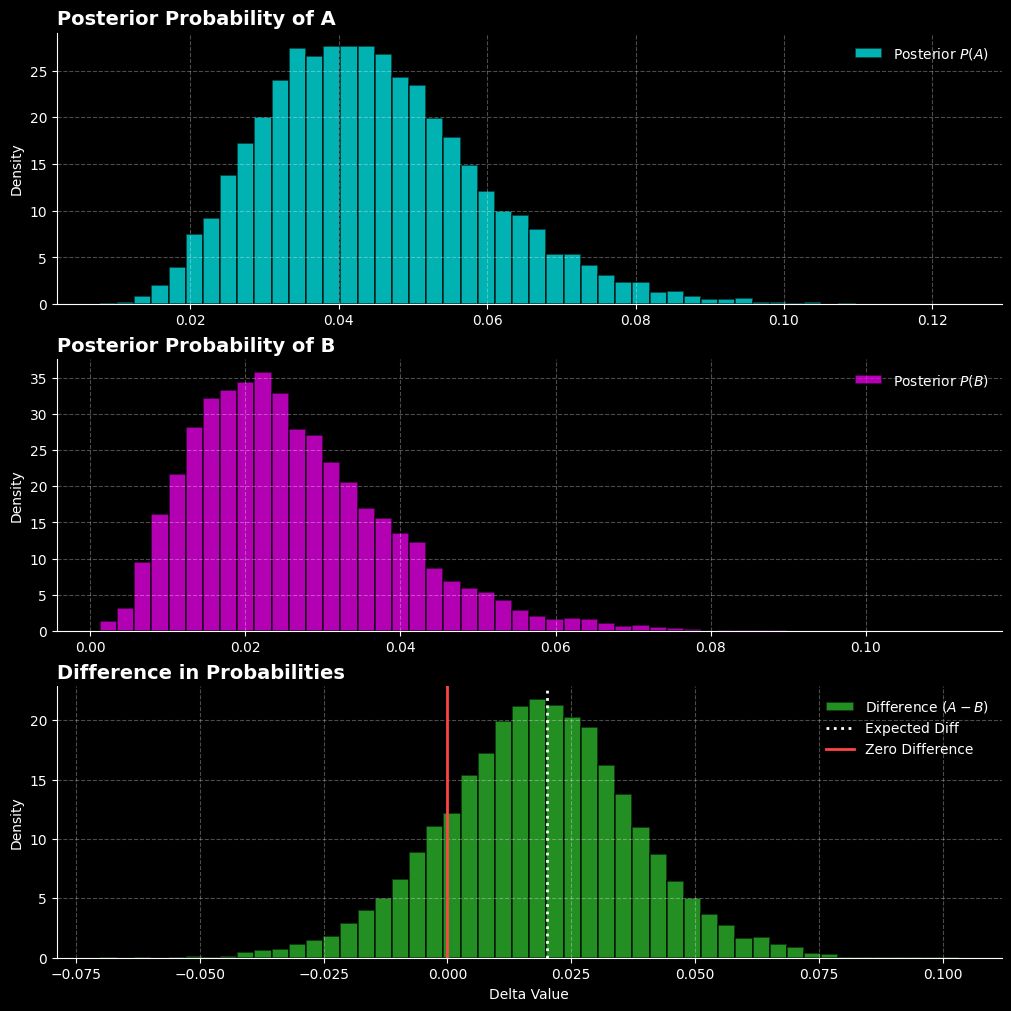

In [42]:
#| label: fig-bayesian-plot-1
#| fig-cap: "Posterior distributions for the conversion rates of variants A and B"

# --- Setup Dark Mode ---
plt.style.use('dark_background')

# Ensure texts are white (sometimes needed depending on Jupyter setup)
plt.rcParams.update({
    "text.color": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white"
})

fig, axes = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)

# Neon colors for pop against dark background
colors = ['#00FFFF', '#FF00FF', '#32CD32'] # Cyan, Magenta, Lime

# --- Plot 1: Posterior P(A) ---
ax = axes[0]
data_a = idata.posterior['A_prior'].values.ravel()
ax.hist(data_a, bins=50, density=True, color=colors[0], alpha=0.7, 
        edgecolor='black', linewidth=1.2, label="Posterior $P(A)$")
ax.set_title("Posterior Probability of A", fontsize=14, loc='left', fontweight='bold')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--')

# --- Plot 2: Posterior P(B) ---
ax = axes[1]
data_b = idata.posterior['B_prior'].values.ravel()
ax.hist(data_b, bins=50, density=True, color=colors[1], alpha=0.7, 
        edgecolor='black', linewidth=1.2, label="Posterior $P(B)$")
ax.set_title("Posterior Probability of B", fontsize=14, loc='left', fontweight='bold')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--')

# --- Plot 3: Difference ---
ax = axes[2]
data_delta = idata.posterior['delta'].values.ravel()
ax.hist(data_delta, bins=50, density=True, color=colors[2], alpha=0.7, 
        edgecolor='black', linewidth=1.2, label="Difference ($A - B$)")
ax.set_title("Difference in Probabilities", fontsize=14, loc='left', fontweight='bold')
ax.set_ylabel("Density")
ax.set_xlabel("Delta Value")

# Vertical Lines
ax.axvline(a_default - b_default, color='white', linestyle=':', linewidth=2, label="Expected Diff")
ax.axvline(0, color='#FF4444', linestyle='-', linewidth=2, label="Zero Difference")

ax.legend(loc='upper right', frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--')

# --- Saving with Transparent Background ---

# The magic argument is transparent=True + bbox_inches='tight' cuts off extra whitespace around the labels
# plt.savefig('dark_bayes_plot_transparent.png', dpi=300, bbox_inches='tight', transparent=True)
# to evaluate probability (idata.posterior['delta'].values > 0).mean()

plt.show()

In [43]:
#| echo: false
#| output: asis

# if the shart is not reflected - print the exact Markdown link syntax
# print('![]({})'.format("BayesianAB_files/figure-markdown_strict/fig-bayesian-plot-1-output-1.png"))

print(f"""\n<p style="text-align: center;">Figure 1. Probability of superiority: {(idata.posterior['delta'].values > 0).mean():.1%}</p>\n""")


<p style="text-align: center;">Figure 1. Probability of superiority: 83.2%</p>



## 🏗️ Part 2: Hierarchical Models (The "Robin Hood" Approach)

When you run many related experiments or compare several variants in the same domain, hierarchical (multilevel) models are a practical way to borrow strength across groups. They reduce variance for small groups (shrinkage) and improve estimation stability. Below is a compact PyMC implementation that models group probabilities as draws from a shared Beta(a, b) prior.

This pattern is useful for dashboarding many A/B results together or for pooling information when sample sizes vary across tests.

### What is hierarchical models

In a hierarchical (or multilevel) model, you assume that the parameters for each group are related and drawn from a common, overarching distribution. This shared distribution is governed by hyper-parameters.

All group-level parameters are drawn from a single, shared distribution defined by hyper-parameters a and b. For example each test's probability is drawn from a shared Beta(a,b), where a and b are themselves parameters to be estimated.

The estimate for any single group is influenced both by its own data and the data from all other groups (via the shared a and b). This is called partial pooling, Say a and b are estimated to best fit all test data, and then every test's probability is pulled slightly toward the overall average defined by a and b.

Estimates for small groups are pulled toward the average (a process called shrinkage), leading to more stable, less extreme estimates

### Which distribution may be used?

Non-Informative Prior for Beta Hyperparameters:
  $$p(a,b) \propto (a+b)^{-5/2}$$

Simplification or approximation of the Jeffreys Prior for the hyper-parameters of the Beta distribution, which is used as a conjugate prior for binomial or Bernoulli likelihoods (common in multiple testing models, e.g., estimating the probability of a true null hypothesis)

When $a$ and $b$ are the shape parameters of Beta distribution, the actual Jeffreys Prior is defined by the Fisher Information matrix:

$$p(a,b) \propto \sqrt{\det(\mathbf{I}(a,b))}$$

The determinant of the Fisher Information matrix for the Beta distribution's parameters is a complex function involving the trigamma function ($\psi'$). Specifically, a known simplification used in some computational Bayesian contexts is related to the mean and total effective count of the Beta distribution.

The term $\tau = a+b$ is often interpreted as the total effective sample size (or precision) of the Beta distribution. The exponent $-5/2$ is a specific value that results from one of the approximations designed to make the prior less influential on the posterior, often for the standard deviation or variance of the underlying distribution.

### Example

In [33]:
#| code-fold: false
#| output: false
# --- 1. Data Definition ---
trials = np.array([842, 854, 862, 821, 839])
successes = np.array([27, 47, 69, 52, 35])

N_GROUPS = len(trials)
# Constraint for Beta parameters (a and b must be > 0)
ALPHA_MIN = 0.01

with pm.Model() as hierarchical_model:

    # --- 2. Hyper-parameter Priors (a and b) ---

    # The Beta shape parameters a and b must be positive.
    # We define them with a minimally informative uniform prior.
    a = pm.Uniform("a", lower=ALPHA_MIN, upper=100)
    b = pm.Uniform("b", lower=ALPHA_MIN, upper=100)

    # --- 3. Custom Precision Prior (pm.Potential) ---
    # The original prior was: log p(a, b) = log((a+b)^-2.5) = -2.5 * log(a + b)
    PRIOR_EXPONENT = -2.5

    # Use pm.Potential to add the custom log-prior term to the model's log(P)
    log_precision_prior = PRIOR_EXPONENT * np.log(a + b)
    pm.Potential("beta_precision_potential", log_precision_prior)

    # --- 4. Group-level Prior (occurrences) ---
    # 'occurrences' is the probability for each group
    # drawn from a Beta distribution defined by the hyper-parameters a and b.
    occurrences = pm.Beta("occurrences", alpha=a, beta=b, shape=N_GROUPS)

    # --- 5. Likelihood (l_obs) ---
    # The observed successes follow a Binomial distribution.
    likelihood = pm.Binomial("likelihood", n=trials, p=occurrences, observed=successes)

    # --- 6. Sampling ---
    # Sampling is now done with pm.sample()
    # 5000 draws, 1000 tune (burn-in)
    idata = pm.sample(draws=1000, tune=1000, cores=-1, chains=2, random_seed=13)

# To view the results:
print(pm.summary(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, occurrences]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 124 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


                  mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a                3.085   1.724   0.317    6.120      0.044    0.031    1437.0   
b               46.208  27.525   0.401   91.413      0.699    0.494    1427.0   
occurrences[0]   0.034   0.006   0.023    0.046      0.000    0.000    2427.0   
occurrences[1]   0.056   0.008   0.041    0.070      0.000    0.000    2514.0   
occurrences[2]   0.079   0.009   0.063    0.097      0.000    0.000    2023.0   
occurrences[3]   0.063   0.008   0.049    0.079      0.000    0.000    2041.0   
occurrences[4]   0.043   0.007   0.030    0.056      0.000    0.000    2291.0   

                ess_tail  r_hat  
a                 1228.0    1.0  
b                 1107.0    1.0  
occurrences[0]    1131.0    1.0  
occurrences[1]    1417.0    1.0  
occurrences[2]    1161.0    1.0  
occurrences[3]    1235.0    1.0  
occurrences[4]    1276.0    1.0  


                  mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a                3.085   1.724   0.317    6.120      0.044    0.031    1437.0   
b               46.208  27.525   0.401   91.413      0.699    0.494    1427.0   
occurrences[0]   0.034   0.006   0.023    0.046      0.000    0.000    2427.0   
occurrences[1]   0.056   0.008   0.041    0.070      0.000    0.000    2514.0   
occurrences[2]   0.079   0.009   0.063    0.097      0.000    0.000    2023.0   
occurrences[3]   0.063   0.008   0.049    0.079      0.000    0.000    2041.0   
occurrences[4]   0.043   0.007   0.030    0.056      0.000    0.000    2291.0   

                ess_tail  r_hat  
a                 1228.0    1.0  
b                 1107.0    1.0  
occurrences[0]    1131.0    1.0  
occurrences[1]    1417.0    1.0  
occurrences[2]    1161.0    1.0  
occurrences[3]    1235.0    1.0  
occurrences[4]    1276.0    1.0  
CPU times: total: 1min 50s
Wall time: 1min 51s


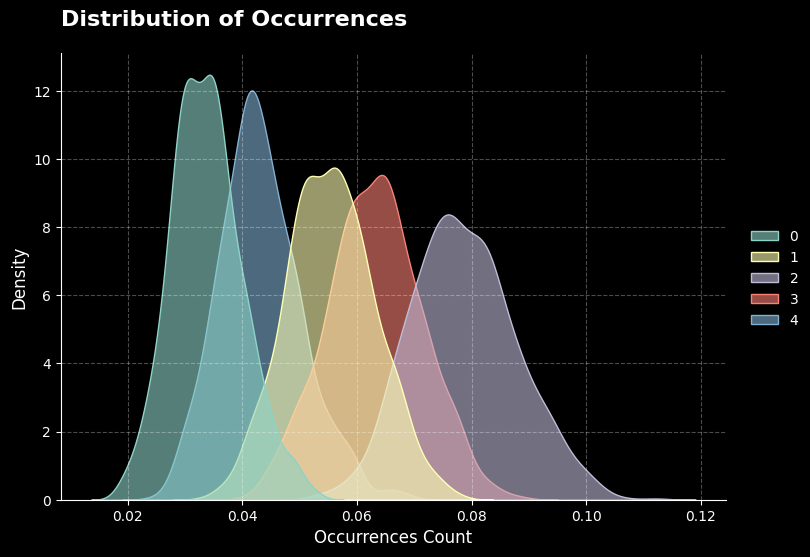

In [34]:
#| label: fig-bayesian-plot-2
#| fig-cap: "Distribution of occurrences for multiple hypotheses"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Activate Dark Mode
plt.style.use('dark_background')

# 2. Use the figure-level function sns.displot
g = sns.displot(
    idata.posterior.occurrences[0, :, :].values, 
    kind='kde', # Use KDE for a smoother distribution line
    color='#00FFFF', # Neon Cyan for high contrast
    fill=True, 
    alpha=0.6,
    height=5, 
    aspect=1.5 # Set figure size/ratio
)

# 3. Apply final aesthetic touches to the single axis
ax = g.ax 
ax.set_title("Distribution of Occurrences", fontsize=16, loc='left', fontweight='bold', pad=20)
ax.set_xlabel("Occurrences Count", fontsize=12)
ax.set_ylabel("Density", fontsize=12)

# Ensure grid lines are subtle
ax.grid(True, alpha=0.3, linestyle='--')

# 4. Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [35]:
#| echo: false
#| output: asis
print(f"""\n<p style="text-align: center;">Figure 2. Posterior probabilities in Hierarchical Model</p>\n""")


<p style="text-align: center;">Figure 2. Posterior probabilities in Hierarchical Model</p>



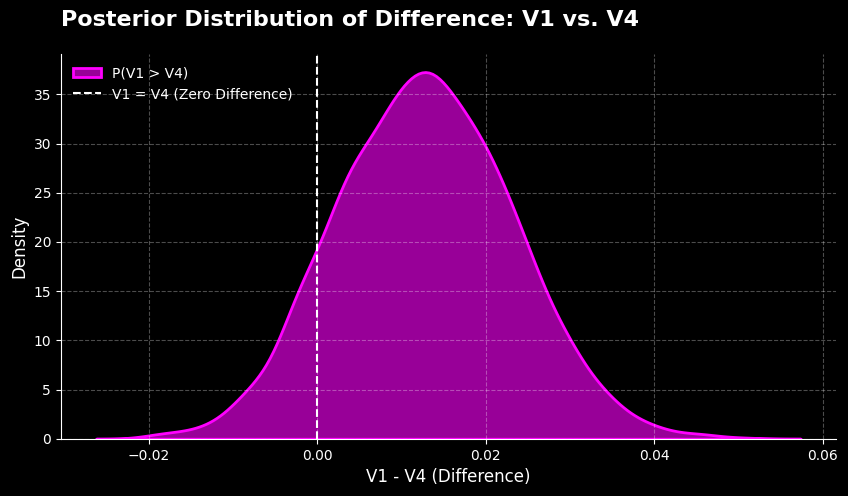

In [36]:
#| label: fig-bayesian-plot-3
#| fig-cap: "Posterior distribution of difference"

plt.style.use('dark_background')

diff_1_vs_4 = (idata.posterior.occurrences[:, :, 1] - idata.posterior.occurrences[:, :, 4]).values.ravel()
prob_v1_gt_v4 = (diff_1_vs_4 > 0).mean()

# Setup Figure and Axis
fig, ax = plt.subplots(figsize=(10, 5))

# Define color (Neon Magenta)
neon_color = '#FF00FF'

# 1. Create the KDE plot
sns.kdeplot(
    diff_1_vs_4, 
    ax=ax,
    fill=True, 
    color=neon_color, 
    alpha=0.6,
    linewidth=2,
    # The label includes the P(V1 > V4) calculation
    label=f"P(V1 > V4)"
)

# 2. Add Zero Line (Crucial for interpretation)
# This white dashed line marks the threshold for the probability calculation
ax.axvline(0, color='white', linestyle='--', linewidth=1.5, label="V1 = V4 (Zero Difference)")

# 3. Apply final aesthetic touches
ax.set_title(
    f"Posterior Distribution of Difference: V1 vs. V4", 
    fontsize=16, 
    loc='left', 
    fontweight='bold', 
    pad=20
)
ax.set_xlabel("V1 - V4 (Difference)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)

# Clean up
ax.legend(loc='upper left', frameon=False, fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--')

plt.show()

In [40]:
#| echo: false
#| output: asis
print(f"""\n<p style="text-align: center;">Figure 3. Probability of superiority: {prob_v1_gt_v4:.1%}</p>\n""")


<p style="text-align: center;">Figure 3. Probability of superiority: 88.7%</p>



## ⚡ Part 3: The Need for Speed (Analytic Bayesian Solutions)

MCMC is great, but sometimes you need speed. For the math nerds among us, the Beta-Binomial conjugacy is pure magic. ✨

If you have a Beta prior and Binomial data, the posterior is ... drumroll ... just another Beta distribution! No complex sampling required - just simple arithmetic. Say there is $Beta(\alpha, \beta)$ prior and $k$ successes in $n$ trials, the posterior is $Beta(\alpha + k, \beta + n - k)$.  This gives us closed-form solutions for the Probability of Superiority (PoS) instantly.

Say we have 10 heads from ten coin flips, what is the probability to get get a head in the next flip?

Using Bayesian approach, where

$ \mathcal{H}$ - hypothesis, $\mathcal{D}$ - data

$P(\mathcal{H}) - prior$

$P(\mathcal{D} | \mathcal{H}) - likelihood $

$P(\mathcal{H} | \mathcal{D}) - posterior $

$$ P(\mathcal{H} | \mathcal{D}) \propto P(\mathcal{D} | \mathcal{H}) P(\mathcal{H}) $$

It can be shown that if

$$ P(\mathcal{H}) = {Beta}(p; \alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} p^{\alpha-1}(1-p)^{\beta-1} $$

$$ P(\mathcal{D} | \mathcal{H}) = {Binom}(p; k, n) = C_{n}^{k} p^{k} (1-p)^{n-k} $$

Then

\begin{split} P(\mathcal{H} | \mathcal{D}) & = P(p | k, n) = {Beta}(p; \alpha + k, \beta + n - k) \end{split}


Proof
$$ P(\mathcal{H} | \mathcal{D}) = \frac{P(\mathcal{D} | \mathcal{H}) P(\mathcal{H})}{P(\mathcal{D})} $$

$$ P(\mathcal{D} | \mathcal{H}) P(\mathcal{H}) = \biggl ( C_{n}^{k} \cdot p^{k} (1-p)^{n-k} \biggr ) \cdot \biggl ( \mathbf{\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}} \cdot p^{\alpha-1} (1-p)^{\beta-1} \biggr ) = C \cdot p^{\alpha+k-1}(1-p)^{\beta+n-k-1} $$

$$ P(\mathcal{D}) = \int_{0}^{1} P(\mathcal{D} | \mathcal{H}) P(\mathcal{H}) dp = C \cdot \int_{0}^{1} p^{\alpha+k-1} (1-p)^{\beta+n-k-1} dp = C \cdot B(\alpha+k, \beta+n-k)$$

Consequently combining those two equations, The Binomial Constant and the Prior Beta Constant are completely canceled out

$$ P(\mathcal{H} | \mathcal{D}) = \frac{1}{B(\alpha+k, \beta+n-k)} p^{\alpha+k-1}(1-p)^{\beta+n-k-1} = {Beta}(p; \alpha + k, \beta + n - k) $$

End of Proof

In case of non-informative prior $Beta(p; 1, 1) $ what basically given Uniform distribution of the prior - Beta function may be presented with a short binomial coefficient formula

$$ B(k+1, n-k+1) = \frac{Г(k+1)Г(n-k+1)}{Г(n+2)} = \frac{k!(n-k)!}{(n+1)!} = \frac{1}{(n+1)\; C_{n}^{k}} $$

In our case the posterior distribution is $ {Beta}(p; k + 1, n - k + 1) $

Hence we can build the predictive interval using this Beta distribution moments:

$$ \mu = \frac{\alpha}{\alpha + \beta} = \frac{k+1}{n+2} $$

This formula for $ \mu $ is also used as the Laplace sequence rule, which requires adding one positive and one negative observation to estimate the posterior probability distribution for a random sample.

Adding second moment

$$ \sigma^2 = {\frac {\alpha \beta }{(\alpha +\beta )^{2}(\alpha +\beta +1)}} = \frac{(k+1)(n-k+1)}{(n+2)^2(n+3)} $$

In [11]:
#| code-fold: false
mu = 11 / 12
sigma = (11 / 12 ** 2 / 13) ** 0.5

print(f"Hence 2 sigma predictive interval for 10/10 successful flips is {mu:.2%} ± {2 * sigma :.2%}")
print(f"Alternatively as a pair of bounds: {mu - 2 * sigma:.2%} - {min(1, mu + 2 * sigma):.2%}")

Hence 2 sigma predictive interval for 10/10 successful flips is 91.67% ± 15.33%
Alternatively as a pair of bounds: 76.34% - 100.00%


But it's not a Normal distribution, so it's not 95% confidence interval, we need to take Beta distribution quantile instead or calculate it precisely. It resembles the approximation that we get using normal distribution quantiles.

In [12]:
#| code-fold: false
l, r = sts.beta.ppf([0.05, 1.0], a=11, b=1)
print(f"Beta predictive interval {l:.2%} - {r:.2%}")

Beta predictive interval 76.16% - 100.00%


Another way is get that number analytically from the integral equation that fully coincides with the value from stats package.

$$ \int_{p_{crit}}^{1} (n+1) \cdot C_n^n \cdot p^n (1-p)^0 dp = 0.95 $$


$$ p_{crit} = \sqrt[n + 1]{0.05}$$

In [13]:
#| code-fold: false
print(f"What makes it an easy computation: p is from {0.05 ** (1/11):.2%} - 100.00%")

What makes it an easy computation: p is from 76.16% - 100.00%


Criterion that is used for analytical model decision making in A/B experiment

$$ P(\lambda_B > \lambda_A) = \int_{p_B > p_A} P(p_A, p_B | \text{Data}) \, dp_A \, dp_B = \sum_{i=0}^{\alpha_B-1} \frac{B(\alpha_A+i, \beta_A+\beta_B)}{(\beta_B+i)B(1+i, \beta_B)B(\alpha_A, \beta_A)} $$

The formula is the result of applying a well-known mathematical identity that allows the cumulative probability of one Beta variable being less than another Beta variable to be expressed as a finite sum of terms involving the Beta function, rather than requiring complex numerical integration. This is why this formula is computationally efficient and preferred for exact Bayesian A/B calculations.

### Rule of three: when no successes are observed 💡

The rule of three is used to provide a simple way of stating an approximate 95% confidence interval in the special case that no successes have been observed -  $(0, 3/n)$, alternatively by symmetry, in case of only successes $(1 - 3/n, 1) $.

On the other hand mathematically, if all conversions are zero, then we simply may build an equation for upper bound

$(1-p)^n \geq \alpha$,  where $\alpha = .05$ and hence $n \leq log_{.95}(.05)$


For example - how many trials needed to challenge the null hypothesis that the success probability is zero?

In [14]:
#| code-fold: false
print("Approximate N:", int(3 / 0.05))
print("Exact N:", 1 + int((np.log(0.05) / np.log(0.95))))

Approximate N: 60
Exact N: 59


__Quick Tip for Zero Successes__: If you launch a test and get zero conversions, don't panic. Use the Rule of Three: your approximate 95% upper bound is simply 3/n. It's a "pretty decent" (and fast) estimate without needing a calculator.

## 😱 Part 4: The Plot Twist (Peeking)

Here is the controversial bit: Bayesian A/B testing is NOT immune to peeking. The Myth: "I can check my Bayesian results whenever I want, and it's always valid!" The Reality: Mathematically, the posterior is valid. BUT, if you use a fixed rule like "Stop when Probability > 95%," you will inflate your False Positive Rate over time. You are essentially fishing for significance. If you stop early just because you crossed a line, you are falling into the same trap as frequentists, but but first things first.

To compare stopping rules and power, the notebook includes a Monte Carlo harness. It simulates repeated experiments, applies frequentist sequential z-tests and several Bayesian stopping rules (naive PoS threshold, expected-loss stopping (OLF), and HDI & PoS combinations), and compares false positive rates and average stopping sample sizes.

In [15]:
#| echo: false
from tqdm.notebook import tqdm

In [16]:
from typing import Callable

n_iterations = 1000

def min_sample_size(mde, mu, sigma, alpha=0.05, power=0.80) -> int:
    """
    Defines superiority one-side z-test sample size

    Args:
        mde: Relative uplift
        mu: Expected Value
        sigma: Square root of variance
        alpha: False Positive Rate, default = 0.05
        power: Experiment power, default = 0.80

    Returns:
        Required sample size to achieve the power
    """
    effect_size = abs(mde) * mu / sigma
    return int(((sts.norm.ppf(1 - alpha) + sts.norm.ppf(power)) / effect_size) ** 2)


def stops_at(is_significant: np.ndarray, sample_size: np.ndarray) -> int:
    """
    Determines the stopping sample size.

    This function identifies the first instance where the input
    condition is True and returns the corresponding sample size.

    Args:
        is_significant: A boolean array of the stop condition for each size
        sample_size: An array of sample sizes.

    Returns:
        The stopping sample size.

    Example:
        >>> stops_at([False, False, True, True], [50, 100, 150, 200])
        150
    """
    if len(is_significant) != len(sample_size):
        raise ValueError("Input arrays must have the same length.")
    w = np.where(is_significant)[0]
    return np.nan if len(w) == 0 else sample_size[w[0]]

def monte_carlo(
    bayesian_stop_rule,
    effect_size: float=0.10,
    aa_test: bool=True,
    alpha: float=0.05,
    peeks: int = 1,
) -> None:

    result = {
        'Frequentist': [],
        'Bayesian': [],
    }

    p = 0.20
    sigma = (p * (1 - p)) ** 0.5
    relative_effect = 0 if aa_test else effect_size

    N = min_sample_size(mde=effect_size, mu=p, sigma=sigma, alpha=alpha)
    n = int(N / peeks)

    print(f"Running {n_iterations} simulations with total sample size {N} that is achieved in {peeks} iterations of {n} size each")

    for seed in tqdm(range(n_iterations)):

        rng = np.random.default_rng(seed)
        binomial_samples = rng.binomial(n=n, p=p*(1+relative_effect), size=peeks)

        sizes = np.arange(n, N + 1, n)
        conversions = np.cumsum(binomial_samples)

        z_scores = [(success / trials - p) / np.sqrt(sigma ** 2 / trials) for success, trials in zip(conversions, sizes)]
        is_prob_high_enough = [
            bayesian_stop_rule(
                success=success,
                trials=trials,
                alpha=alpha,
                p=p,
                effect_size=effect_size
            ) for success, trials in zip(conversions, sizes)
        ]

        result['Frequentist'].append(stops_at(z_scores > sts.norm.ppf(1 - alpha), sizes))
        result['Bayesian'].append(stops_at(is_prob_high_enough, sizes))

    result = "\n".join([
        f"Frequentist Rejected Rate: {np.mean(~np.isnan(result['Frequentist']))}",
        f"Frequentist Required Sample Size: {int(np.nanmean(result['Frequentist']))}",
        f"Bayesian Rejected Rate: {np.mean(~np.isnan(result['Bayesian']))}",
        f"Bayesian Required Sample Size: {int(np.nanmean(result['Bayesian']))}",
    ])

    print(result)

    return

def POS(success: int, trials: int, alpha: float, p: float, **kwargs) -> bool:
    """ Probability of Superiority decision rule """
    return sts.beta.cdf(p, a = 1 + success, b = 1 + trials - success) < alpha

### Correctness

In [17]:
#| code-fold: false
monte_carlo(bayesian_stop_rule=POS, peeks=1, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 1 iterations of 2473 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.06
Frequentist Required Sample Size: 2473
Bayesian Rejected Rate: 0.06
Bayesian Required Sample Size: 2473


In [18]:
#| code-fold: false
monte_carlo(bayesian_stop_rule=POS, peeks=5, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 5 iterations of 494 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.126
Frequentist Required Sample Size: 1015
Bayesian Rejected Rate: 0.126
Bayesian Required Sample Size: 1015


### A/B design power

In [19]:
#| code-fold: false
monte_carlo(bayesian_stop_rule=POS, peeks=5, aa_test=False)

Running 1000 simulations with total sample size 2473 that is achieved in 5 iterations of 494 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.855
Frequentist Required Sample Size: 1146
Bayesian Rejected Rate: 0.855
Bayesian Required Sample Size: 1146


That is a crucial observation and it points to a common misunderstanding about Bayesian A/B testing:

No, the standard Bayesian approach does not handle peeking (optional stopping) correctly by default if your goal is to control the frequentist Type I Error Rate (False Positive Rate).


While the Bayesian interpretation of results remains valid at any time, using a fixed threshold (e.g., stopping when $P(A > B) > 95\%$) and checking repeatedly will lead to an inflated False Positive Rate over many hypothetical experiments, just like in the frequentist approach.

What is NOT Affected (The Bayesian Advantage) The Posterior Distribution and the Probability of Superiority — is always valid, regardless of when you look at the data.

What IS Affected (The Peeking Problem) The problem arises when you use a fixed decision rule (like the $95\%$ threshold) to stop the test prematurely, based on the outcome.

The Myth: The common claim that "Bayesian testing is immune to peeking" is overstated. It is only immune in the sense that the posterior is always mathematically correct. It is not immune in the sense that it prevents the inflation of the frequentist Type I Error Rate when using a simple, fixed stopping threshold

## 🛡️ Part 5: How to Peek Safely

### How Bayesian Methods Truly Handle Peeking

 To safely peek and stop early in a Bayesian framework, you need to base your decision on a metric that incorporates the cost of a wrong decision, not just the probability of a difference.

 The correct Bayesian decision procedure is to stop when:
  - Expected Loss (EL) is Minimized: You stop the test when the Expected Loss of choosing the suboptimal variant falls below a commercially acceptable threshold $\epsilon$. This naturally accounts for uncertainty.13 If the posterior distributions are still wide (high uncertainty), the loss will be high, and you won't stop.

$$ E[L](p_a > p_b) = \int_0^1\int_0^1L(p_a,p_b, p_a > p_b)P(p_a|a,b,n_a,k_a)P(p_b|a,b,n_b,k_b)dp_adp_b $$

  - Sequential Designs (Like Multi-Armed Bandits): Techniques like Thompson Sampling are inherently Bayesian and sequential. They don't have a stopping rule based on error rates; they simply choose the best variant to show next based on the posterior, which naturally directs more traffic to the likely winner, making the experiment efficient without needing a fixed sample size.

### Example of Loss function applied

Define the Opportunity Loss Function $L(p_A, p_B)$, which is the regret you incur by choosing a variant that is not the best.If we Choose B, the loss only happens if $p_A > p_B$: $$L(\text{Choose B}) = \max(0, p_A - p_B)$$ If we Choose A, the loss only happens if $p_B > p_A$: $$L(\text{Choose A}) = \max(0, p_B - p_A)$$

Using known properties and identities related to the Beta function, this complex double integral for Opportunity Loss function can be transformed into a closed-form summation:

$$ EL_A = \sum_{i=0}^{\alpha_B-1} \frac{\alpha_A \cdot B(\alpha_A+i+1, \beta_A+\beta_B)}{\beta_A \cdot B(i+1, \beta_B) \cdot B(\alpha_A, \beta_A)} - \sum_{i=0}^{\alpha_B-1} \frac{\alpha_B \cdot B(\alpha_A+i, \beta_A+\beta_B+1)}{(\beta_B+i) \cdot B(i+1, \beta_B) \cdot B(\alpha_A, \beta_A)} $$


The Formula for one-sample test is against benchmark $\lambda_0$:

$$ EL_A = \lambda_0 \cdot I_{\lambda_0}(\alpha, \beta) - \frac{\alpha}{\alpha+\beta} \cdot I_{\lambda_0}(\alpha+1, \beta) $$

Python Implementation note that `betainc` $(\alpha, \beta, \lambda)$ calculates $I_{\lambda}(\alpha, \beta)$, that is an equivalent of `sts.beta.cdf`$(\lambda, \alpha, \beta)$

In [20]:
from scipy.special import betainc

def calculate_opportunity_loss_one_sample(
    k: int,
    n: int,
    lambda_0: float,
    prior_alpha: int = 1,
    prior_beta: int = 1,
) -> float:
    """
    Calculates the Expected Loss of choosing the observed variant against
    a benchmark using the analytical formula. Absolute value of conversion loss.
    Non-informative conjugate prior is used by Default.

    Args:
        k (int): Observed successes (conversions).
        n (int): Observed trials (sizes).
        lambda_0 (float): The fixed conversion rate benchmark.
        prior_alpha (int): Prior alpha hyper-parameter.
        prior_beta (int): Prior beta hyper-parameter.

    Returns:
        float: The Expected Loss of choosing the observed variant.
    """

    # Calculate Posterior Parameters (alpha and beta)
    alpha = k + prior_alpha
    beta = n - k + prior_beta

    # --- Term 1: Probability of Loss ---
    # Calculates I_lambda_bench(alpha, beta) = P(lambda_obs < lambda_bench)
    # The term is: lambda_bench * P(lambda_obs < lambda_bench)
    term1 = lambda_0 * betainc(alpha, beta, lambda_0)

    # --- Term 2: Weighted Expected Value ---
    # The fraction part: alpha / (alpha + beta) is the mean of Beta(alpha, beta)
    term2 = alpha / (alpha + beta) * betainc(alpha + 1, beta, lambda_0)

    return term1 - term2

Frequentist: We must collect $N$ samples to have an $1-\beta$ chance of detecting a $MDE$ difference with $\alpha$ error.

Bayesian: We will stop the test when the average potential loss incurred by choosing the sub-optimal variant is less than $\epsilon$ percentage points. By setting a small $\epsilon$, you ensure that the test continues until the potential future regret (loss) is extremely low, thus ensuring a high degree of confidence in the final decision while retaining the ability to peek safely

Adjust Monte Carlo procedure with another Bayesian stopping rule

In [21]:
def OLF(success: int, trials: int, p: float, effect_size: float, **kwargs) -> bool:
    """Opportunity Loss Function stopping rule. Epsilon is usually set to a fraction of MDE"""
    fraction = 1 / 100
    epsilon = fraction * effect_size * p
    return calculate_opportunity_loss_one_sample(success, trials, lambda_0=p) < epsilon

In [22]:
#| code-fold: false
monte_carlo(bayesian_stop_rule=OLF, peeks=30, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 30 iterations of 82 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.249
Frequentist Required Sample Size: 590
Bayesian Rejected Rate: 0.21
Bayesian Required Sample Size: 839


So, Loss Function doesn't save from Peeking problem, it's even more vulnerable than well-known p-value approach

We need another piece of the puzzle ...

### Here comes the sun 🌤️ ... and HDI

Highest Density Interval (sometimes called Highest Posterior Density Interval).

Definition: The $X\%$ HDI is the narrowest interval that contains $X\%$ of the probability mass of the posterior distribution.

Purpose: It is the Bayesian equivalent of the frequentist Confidence Interval (CI), but unlike the CI, you can state that there is an $X\%$ probability that the true parameter value (e.g., the true conversion rate) lies within the HDI.

The width of the HDI is simply (Upper Bound - Lower Bound). It is a direct and intuitive measure of the remaining uncertainty. A wide HDI means your posterior is flat and uncertain; a narrow HDI means your posterior is sharply peaked and confident.

In [23]:
import arviz as az

def calculate_beta_hdi_width(alpha: float, beta: float, hdi_prob=0.95, num_samples=10_000) -> float:
    """
    Calculates the Highest Density Interval (HDI) for a Beta distribution
    using Monte Carlo sampling and the arviz library.

    The calculation of the HDI is an iterative process that must find
    the interval boundary points where the probability density is equal,
    while the area between the points equals the target probability.

    Since Beta distribution is generally not symmetrical, the HDI bounds are not
    the same as the quantiles, which is why a specialized function is needed.

    Args:
        alpha (float): The posterior alpha parameter (k_obs + prior_alpha).
        beta (float): The posterior beta parameter (n_obs - k_obs + prior_beta).
        hdi_prob (float): The target probability mass (e.g., 0.95 for 95% HDI).
        num_samples (int): Number of samples to draw for Monte Carlo calculation.

    Returns:
        tuple: (lower_bound, upper_bound, width)
    """
    posterior_samples = sts.beta.rvs(a=alpha, b=beta, size=num_samples)

    # designed to work on posterior samples
    hdi_interval = az.hdi(posterior_samples, hdi_prob=hdi_prob)

    lower_bound = hdi_interval[0]
    upper_bound = hdi_interval[1]

    return upper_bound - lower_bound

Let's update Monte Carlo once again with a combination of PoS and HDI stopping what represent business and statistical robustness respectively, shall we? - Note that HDI density affects the inference vastly and you'd better experiment to pick up a good for for the data.

In [24]:
print(f"Width is multiplied by {round(calculate_beta_hdi_width(100, 100, .99) / calculate_beta_hdi_width(100, 100, 0.8), 2)} when increase required density from 0.8 to 0.99")

Width is multiplied by 1.98 when increase required density from 0.8 to 0.99


In [25]:
def HDI(success: int, trials: int, alpha: float, p: float, effect_size: float) -> bool:
    """ PoS combined with 95% HDI stopping rule """
    return (
        # checks if 95% of posterior distribution is narrow enough and lays in ± MDE
        (calculate_beta_hdi_width(1 + success, 1 + trials - success) < 2 * effect_size * p)
        # checks if posterior distribution by 95% chance better
        and POS(success, trials, alpha, p)
    )

Correctness

In [26]:
#| code-fold: false
monte_carlo(bayesian_stop_rule=OLF, peeks=1, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 1 iterations of 2473 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.06
Frequentist Required Sample Size: 2473
Bayesian Rejected Rate: 0.069
Bayesian Required Sample Size: 2473


In [27]:
#| code-fold: false
monte_carlo(bayesian_stop_rule=HDI, peeks=10, aa_test=True)

Running 1000 simulations with total sample size 2473 that is achieved in 10 iterations of 247 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.193
Frequentist Required Sample Size: 876
Bayesian Rejected Rate: 0.1
Bayesian Required Sample Size: 1924


Power

In [28]:
#| code-fold: false
monte_carlo(bayesian_stop_rule=HDI, peeks=5, aa_test=False)

Running 1000 simulations with total sample size 2473 that is achieved in 5 iterations of 494 size each


  0%|          | 0/1000 [00:00<?, ?it/s]

Frequentist Rejected Rate: 0.855
Frequentist Required Sample Size: 1146
Bayesian Rejected Rate: 0.818
Bayesian Required Sample Size: 2035


HDI accompanied by Probability of Superiority is a good criterion, although very strict if you increase the required density for HDI from 80% above 95% and it hence requires bigger sample size than Frequentist approach.

Combination of HDI and PoS checks makes the criterion less sensitive to peeking, however it's yet not fully immune.

### Stopping Rules Overview

This table breaks down three common criteria used in Bayesian A/B testing, highlighting their function and their **robustness against peeking** (stopping a test too early based on transient results).

| Criterion | Function / Definition | Robustness Against Peeking |
| :--- | :--- | :--- |
| **Probability of Superiority (PoS)** | Measures how often the posterior probability of $\lambda_B$ is greater than $\lambda_A$ (i.e., $P(\lambda_B > \lambda_A)$). | **Low Robustness.** The threshold can be quickly and spuriously crossed by early noise or transient fluctuations. |
| **Expected Loss (EL)** | Measures the average **Cost or Regret** of selecting the inferior variant. | **High Robustness.** Requires the posterior distribution to be **tight enough** that the potential loss (regret) is small, preventing premature stopping. |
| **HDI Width** | Measures the **Precision** or **Uncertainty** of the posterior distribution (e.g., the width of the 95% credible interval). | **High Robustness.** Forces the test to continue until the uncertainty is **low** (the HDI is narrow), regardless of the posterior mean, ensuring adequate data collection. |

## 📝 Conclusions & Practical Recommendations

- Use the posterior (and PoS) to *interpret* results, but prefer decision-theoretic stopping when making business choices: stop when the expected loss of choosing the sub-optimal variant is below a tolerated threshold.
- . Combine HDI (precision) with PoS (direction) for a conservative, safe stopping rule - but higher density HDI thresholds require larger samples.
- When many variants or small groups are present, hierarchical models provide safer estimates via partial pooling.
- If your goal is to guarantee frequentist properties (e.g., Type I control under peeking), design the sequential procedure explicitly: group sequential testing with alpha-spending function or always valid inference approach - [Sequential Testing Guide](https://npodlozhniy.github.io/posts/sequential-testing/) will let you know all you need

Further experiments to try:
- Replace uniform priors with domain-informed priors when available.
- Explore Thompson Sampling for continuous allocation instead of fixed-sample stopping.
- Visualize posterior trajectories and stopping-rule trade-offs across simulated peeks.

Thanks for reading, feel free to fork this notebook and go forth, experiment with your own traffic and loss thresholds as well as react to the post below, and may your posteriors always be narrow!